# Astr 257 HR Diagram, Aditya Sengupta

In [1]:
!which python

/Users/adityasengupta/opt/anaconda3/envs/astr257/bin/python


In [2]:
import astropy
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from matplotlib import pyplot as plt
import numpy as np
from os import path
from photutils.centroids import centroid_sources, centroid_com

In [3]:
datapath = "../../../Project 2--HR Diagram/data/"
getlims = ZScaleInterval().get_limits
def view_as_ds9(img, **kwargs):
    vmin, vmax = getlims(img)
    if vmin > vmax:
        vmin, vmax = vmax, vmin
    plt.imshow(img, vmin=vmin, vmax=vmax, **kwargs)

In [4]:
def fname_to_data(fname, calib):
    return np.dstack([fits.open(path.join(datapath, calib, fname + str(i) + ".fits"))[0].data for i in range(3)]).astype(np.float64)

darks, biases, flatsB, flatsV = map(lambda x: fname_to_data(x, "calibration"), ["dark", "bias", "flatB", "flatV"])
landBs, landVs, ngcBs, ngcVs = map(lambda x: fname_to_data(x, "ngc 6819"), ["land_b", "land_v", "ngc_b", "ngc_v"])

In [5]:
# before we do anything else, let's make sure all the exposures are the same
# i threw the headers out when I loaded the data just now, so let's load the fits files again one by one
fits.open(path.join(datapath, "ngc 6819", "ngc_v0.fits"))[0].header['EXPTIME'] # etc
# darks were 60 seconds
# biases were 0 seconds (obv)
# flatsB were 30 seconds
# flatsV were 10 seconds
# landB were 60 seconds
# landV were 60 seconds
# ngcB were 60 seconds
# ngcV were 60 seconds

60

In [52]:
med_dark, med_bias = map(lambda x: np.nanmedian(x, axis=2), [darks, biases])
for i in range(3):
    darks[:,:,i] = med_dark
    biases[:,:,i] = med_bias

mediandiv = lambda data: np.nanmedian(data, axis=(0,1))

flatsB_minus_darks = mediandiv((flatsB - darks / 2 - biases))
flatsV_minus_darks = mediandiv((flatsV - darks / 6 - biases))

corr_landBs, corr_ngcBs = map(lambda x: (x - darks) / flatsB_minus_darks, [landBs, ngcBs])
corr_landVs, corr_ngcVs = map(lambda x: (x - darks) / flatsV_minus_darks, [landVs, ngcVs])

landB, landV, ngcB, ngcV = map(lambda x: np.nanmedian(x, axis=2), [corr_landBs, corr_landVs, corr_ngcBs, corr_ngcVs])

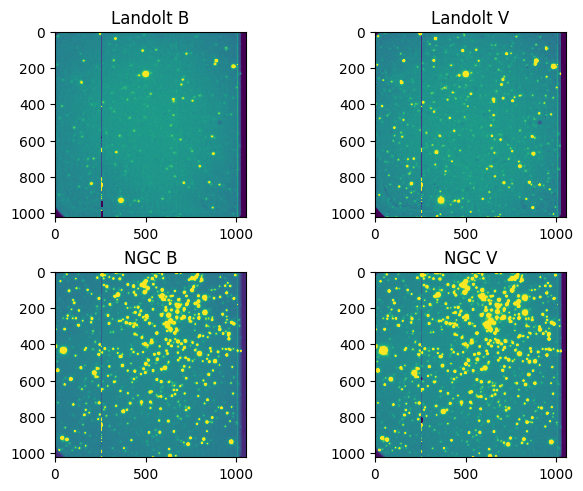

In [53]:
mosaic="AB;CD"
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
for (pos, d, n) in zip(['A', 'B', 'C', 'D'], [landB, landV, ngcB, ngcV], ["Landolt B", "Landolt V", "NGC B", "NGC V"]):
    vmin, vmax = getlims(d)
    im = ax_dict[pos].imshow(d, vmin=vmin, vmax=vmax)
    ax_dict[pos].set_title(n)
    # plt.colorbar(im, ax=ax_dict[pos])

In [54]:
fits.writeto("landB_corr.fits", landB, overwrite=True)

In [55]:
# create an IterativelySubtractedPSFPhotometry object
from photutils.psf import BasicPSFPhotometry

segmentation map - image with a mask for every object it's identified
looks like splotches on a canvas, one splotch per source
overlay with origin image


In [56]:
from astropy.table import Table
from astropy.stats import SigmaClip
from photutils.background import MedianBackground
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.detection import DAOStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF
sigma_clip = SigmaClip(sigma=3.0)


In [57]:
fix = lambda img: np.delete(img[:, :990], 256, 1)
if ngcB.shape[1] == 1056:
    ngcB, ngcV, landB, landV = map(fix, [ngcB, ngcV, landB, landV])

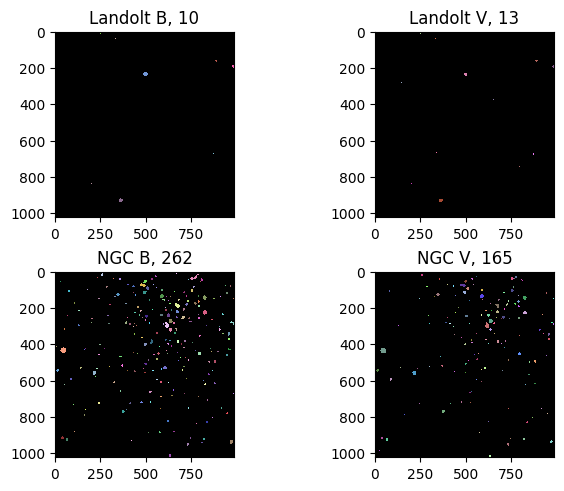

In [66]:
from photutils.segmentation import detect_sources
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
for (pos, d, n) in zip(['A', 'B', 'C', 'D'], [landB, landV, ngcB, ngcV], ["Landolt B", "Landolt V", "NGC B", "NGC V"]):
    seg_i = detect_sources(d, threshold=0.04, npixels=9)
    im = ax_dict[pos].imshow(seg_i, cmap=seg_i.cmap, interpolation='nearest')
    ax_dict[pos].set_title(f"{n}, {seg_i.nlabels}")
    # plt.colorbar(im, ax=ax_dict[pos])

In [73]:
photometry = BasicPSFPhotometry(
    group_maker = DAOGroup(crit_separation=3),
    bkg_estimator = MedianBackground(sigma_clip),
    psf_model = IntegratedGaussianPRF(),
    fitshape = 51,
    finder = DAOStarFinder(threshold=0.04, fwhm=(5)), # tune fwhm based on seeing - 1.2 arcsec in px. Measurable with ds9/by eye 
    fitter = LevMarLSQFitter(),
    aperture_radius = 51
)

In [74]:
landB_phot = photometry(landB)
#view_as_ds9(landB - photometry.get_residual_image())

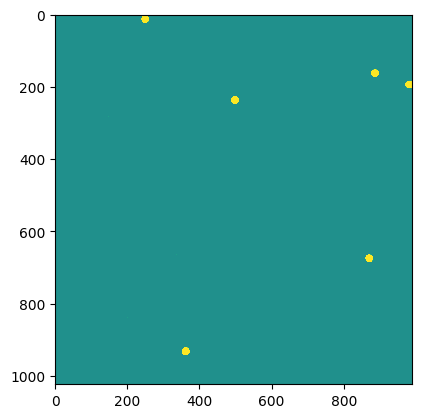

In [75]:
landV_phot = photometry(landV)
view_as_ds9(landV - photometry.get_residual_image())

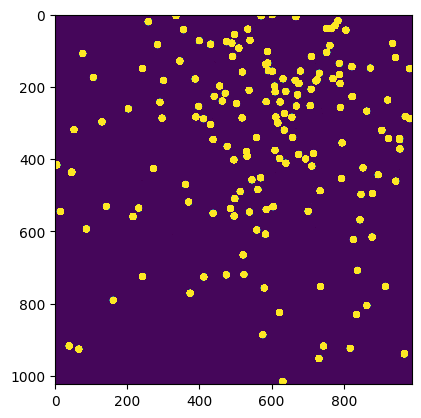

In [76]:
ngcB_phot = photometry(ngcB)
view_as_ds9(ngcB - photometry.get_residual_image())

In [77]:
ngcV_phot = photometry(ngcV)
# view_as_ds9(ngcV - photometry.get_residual_image())

In [78]:
len(landB_phot), len(landV_phot), len(ngcB_phot), len(ngcV_phot)

(3, 6, 164, 100)

In [314]:
ngcB_phot.sort("x_fit")
ngcV_phot.sort("x_fit")

In [315]:
ngcB_phot["x_fit"]

3.5617238945091496
4.7300182349413715
14.255019251573293
23.44947502686925
29.31113279838564
39.12444015490477
45.7797375211648
52.281841107540814
52.82635578059365
63.91555831032532
65.4445118119145


In [319]:
"""Crossmatching pseudocode:

count up (vcount) from 0 to the number of stars in V (which is more)
and have an index (bidx) starting from 0 for the stars in B
for each star (vstar) enumerated by vcount:
    look at stars in the list (max(bcount - 5, 0), min(bcount + 5, bmax)) # tune the 5 if I can't crossmatch everything in B
    compute the distance between vstar and each star on the list ( sqrt ((vstar.x - lst.x) ** 2 + (vstar.y - lst.y) ** 2) )
    if any of those distances are less than 1px, note vcount and bidx in a dict and set bidx to the new match's index 
    if not, we have no match so just increment vcount by 1 and move on
terminate when vcount = vmax and hopefully len(dict) is len(bmax) or not far off
    """;